In [1]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *
import segmentation_models_pytorch as smp


from pathlib import Path
import random

In [2]:
import torch
torch.cuda.set_device(1)

In [3]:
%matplotlib inline
import numpy as np

In [4]:
number_of_the_seed = 2020

random.seed(number_of_the_seed)
set_seed(number_of_the_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
path = Path("./")
path_images = path/"1. Images/1. Training Set"
path_labels = path/"2. Groundtruths/1. Training Set"

In [6]:
get_y_fn = lambda x: Path(str(x).replace("1. Images","2. Groundtruths"))

In [7]:
codes = ['BG','FG']

In [8]:
monitor_training="dice_multi"
comp_training=np.greater

monitor_evaluating="dice"
comp_evaluating=np.greater

patience=5

In [9]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    Flip,
    VerticalFlip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

In [10]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    
transformPipeline=Compose([
                        Flip(p=0.5),
                        VerticalFlip(p=0.5),
                        Transpose(p=0.5),
                        Rotate(p=0.40,limit=180),GridDistortion(),CLAHE(),ShiftScaleRotate(),OpticalDistortion()
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transformPipeline)

In [11]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        # Change 255 for 4
        mask[mask==255]=1
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

In [12]:
path_manual_img = path_images
path_manual_lbl = path_labels

1. Images/1. Training Set/mmac_task_2_train_LC_0007.png


<Axes: >

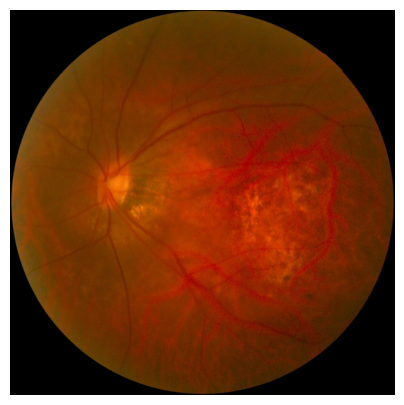

In [13]:
fnames_manual = get_image_files(path_manual_img)
lbl_names_manual = get_image_files(path_manual_lbl)

# open and show image
img_f = fnames_manual[10]
print(img_f)
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [14]:
print(get_y_fn(img_f))

2. Groundtruths/1. Training Set/mmac_task_2_train_LC_0007.png


<Axes: >

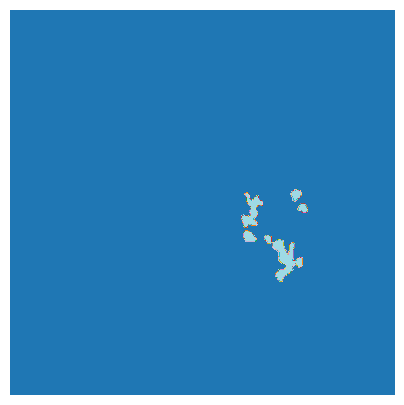

In [15]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [16]:
bs = 4

In [17]:
codes

['BG', 'FG']

In [18]:
trainDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[Resize((800,800)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

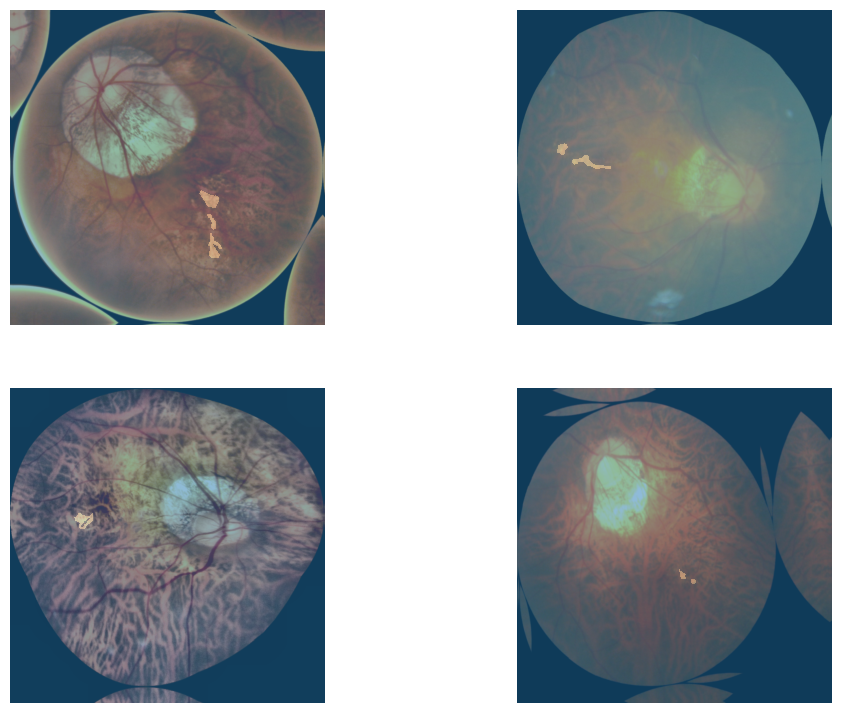

In [19]:
dlsTrain = trainDB.dataloaders(path_images,bs=bs)

dlsTrain.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [23]:
class FPN(nn.Module):
    def __init__(self, input_channels:list, output_channels:list):
        super().__init__()
        self.convs = nn.ModuleList(
            [nn.Sequential(nn.Conv2d(in_ch, out_ch*2, kernel_size=3, padding=1),
             nn.ReLU(inplace=True), nn.BatchNorm2d(out_ch*2),
             nn.Conv2d(out_ch*2, out_ch, kernel_size=3, padding=1))
            for in_ch, out_ch in zip(input_channels, output_channels)])
        
    def forward(self, xs:list, last_layer):
        hcs = [F.interpolate(c(x),scale_factor=2**(len(self.convs)-i),mode='bilinear') 
               for i,(c,x) in enumerate(zip(self.convs, xs))]
        hcs.append(last_layer)
        return torch.cat(hcs, dim=1)

class UnetBlock(Module):
    def __init__(self, up_in_c:int, x_in_c:int, nf:int=None, blur:bool=False,
                 self_attention:bool=False, **kwargs):
        super().__init__()
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, **kwargs)
        self.bn = nn.BatchNorm2d(x_in_c)
        ni = up_in_c//2 + x_in_c
        nf = nf if nf is not None else max(up_in_c//2,32)
        self.conv1 = ConvLayer(ni, nf, norm_type=None, **kwargs)
        self.conv2 = ConvLayer(nf, nf, norm_type=None,
            xtra=SelfAttention(nf) if self_attention else None, **kwargs)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, up_in:Tensor, left_in:Tensor) -> Tensor:
        s = left_in
        up_out = self.shuf(up_in)
        cat_x = self.relu(torch.cat([up_out, self.bn(s)], dim=1))
        return self.conv2(self.conv1(cat_x))
        
class _ASPPModule(nn.Module):
    def __init__(self, inplanes, planes, kernel_size, padding, dilation, groups=1):
        super().__init__()
        self.atrous_conv = nn.Conv2d(inplanes, planes, kernel_size=kernel_size,
                stride=1, padding=padding, dilation=dilation, bias=False, groups=groups)
        self.bn = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()

        self._init_weight()

    def forward(self, x):
        x = self.atrous_conv(x)
        x = self.bn(x)

        return self.relu(x)

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

class ASPP(nn.Module):
    def __init__(self, inplanes=512, mid_c=256, dilations=[6, 12, 18, 24], out_c=None):
        super().__init__()
        self.aspps = [_ASPPModule(inplanes, mid_c, 1, padding=0, dilation=1)] + \
            [_ASPPModule(inplanes, mid_c, 3, padding=d, dilation=d,groups=4) for d in dilations]
        self.aspps = nn.ModuleList(self.aspps)
        self.global_pool = nn.Sequential(nn.AdaptiveMaxPool2d((1, 1)),
                        nn.Conv2d(inplanes, mid_c, 1, stride=1, bias=False),
                        nn.BatchNorm2d(mid_c), nn.ReLU())
        out_c = out_c if out_c is not None else mid_c
        self.out_conv = nn.Sequential(nn.Conv2d(mid_c*(2+len(dilations)), out_c, 1, bias=False),
                                    nn.BatchNorm2d(out_c), nn.ReLU(inplace=True))
        self.conv1 = nn.Conv2d(mid_c*(2+len(dilations)), out_c, 1, bias=False)
        self._init_weight()

    def forward(self, x):
        x0 = self.global_pool(x)
        xs = [aspp(x) for aspp in self.aspps]
        x0 = F.interpolate(x0, size=xs[0].size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x0] + xs, dim=1)
        return self.out_conv(x)
    
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

In [24]:
class UneXt50(nn.Module):
    def __init__(self, stride=1, **kwargs):
        super().__init__()
        #encoder
        m = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models',
                           'resnext50_32x4d_ssl')
        self.enc0 = nn.Sequential(m.conv1, m.bn1, nn.ReLU(inplace=True))
        self.enc1 = nn.Sequential(nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1),
                            m.layer1) #256
        self.enc2 = m.layer2 #512
        self.enc3 = m.layer3 #1024
        self.enc4 = m.layer4 #2048
        #aspp with customized dilatations
        self.aspp = ASPP(2048,256,out_c=512,dilations=[stride*1,stride*2,stride*3,stride*4])
        self.drop_aspp = nn.Dropout2d(0.5)
        #decoder
        self.dec4 = UnetBlock(512,1024,256)
        self.dec3 = UnetBlock(256,512,128)
        self.dec2 = UnetBlock(128,256,64)
        self.dec1 = UnetBlock(64,64,32)
        self.fpn = FPN([512,256,128,64],[16]*4)
        self.drop = nn.Dropout2d(0.1)
        self.final_conv = ConvLayer(32+16*4, 1, ks=1, norm_type=None, act_cls=None)
        
    def forward(self, x):
        enc0 = self.enc0(x)
        enc1 = self.enc1(enc0)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.aspp(enc4)
        dec3 = self.dec4(self.drop_aspp(enc5),enc3)
        dec2 = self.dec3(dec3,enc2)
        dec1 = self.dec2(dec2,enc1)
        dec0 = self.dec1(dec1,enc0)
        x = self.fpn([enc5, dec3, dec2, dec1], dec0)
        x = self.final_conv(self.drop(x))
        x = F.interpolate(x,scale_factor=2,mode='bilinear')
        return x

#split the model to encoder and decoder for fast.ai
split_layers = lambda m: [list(m.enc0.parameters())+list(m.enc1.parameters())+
                list(m.enc2.parameters())+list(m.enc3.parameters())+
                list(m.enc4.parameters()),
                list(m.aspp.parameters())+list(m.dec4.parameters())+
                list(m.dec3.parameters())+list(m.dec2.parameters())+
                list(m.dec1.parameters())+list(m.fpn.parameters())+
                list(m.final_conv.parameters())]

In [25]:
import pytorch_toolbelt.losses as L


lovasz = L.LovaszLoss()

def symmetric_lovasz(outputs, targets):
    return 0.5*(lovasz(outputs, targets) + lovasz(-outputs, 1.0 - targets))

In [26]:
model = UneXt50().cuda()
learn = Learner(data, model, metrics=[DiceMulti(),Dice()],loss_func=symmetric_lovasz,opt_func=ranger).to_fp16()

Using cache found in /home/joheras/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


In [27]:
fname="UneXt50"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    # EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]

In [28]:
learn.fit_flat_cos(100, 1e-3,cbs=callbacksFitBeforeUnfreeze)

AttributeError: module 'fastai.callback.data' has no attribute 'train'

In [23]:
# learn1 = Learner(dlsTrain,model)

In [24]:
# learn1.load('deeplab-resnet50')

In [26]:
aux=learn.model
aux=aux.cpu()

torch.save(aux,'deeplab-efficientnet-lacquer.pth')